# Lab14: NumPy + OpenCV

## Lab Goals

**Demo1**: Change crying emoji into smiley emoji

**Demo2**: Do histogram equalization on provided image

If you are not using docker containers or devcontainers
```bash
    pip install numpy opencv-python matplotlib  
```

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_img(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Demo1

### Step 0. Load Image

replace ```'your_image.jpg'``  with the path to the sad-man image

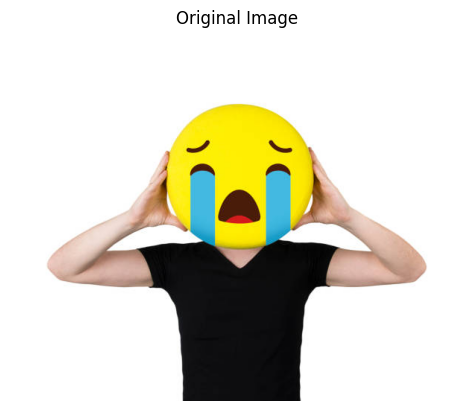

In [3]:
img = cv2.imread('sad_man.jpg')
if img is None:
    raise ValueError("Image not found. Please check the path.")
show_img(img, "Original Image")

### Step 1. Color tracker - yellow

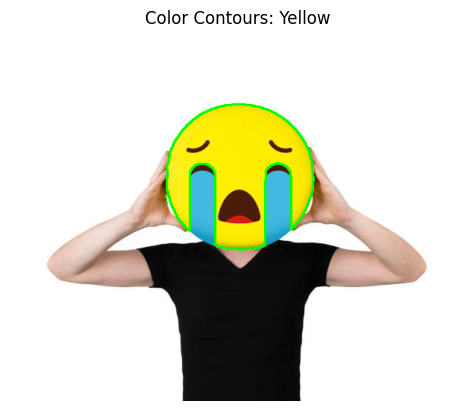

In [4]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(hsv, (20, 100, 100), (40, 255, 255))

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
show_img(img_contours, "Color Contours: Yellow")

### Step 2. Bound the roi with a box

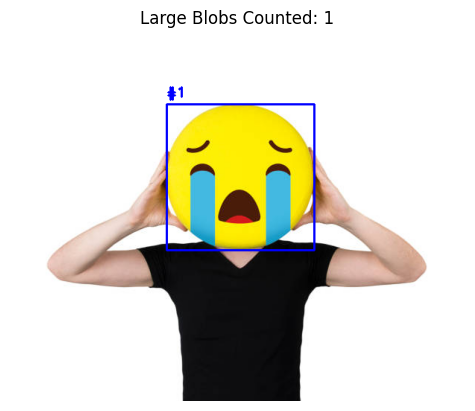

In [5]:
min_area = 500
img_blobs = img.copy()
count = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > min_area:
        count += 1
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_blobs, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img_blobs, f"#{count}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

show_img(img_blobs, f"Large Blobs Counted: {count}")

### Step 3. Replace crying face with smiley face

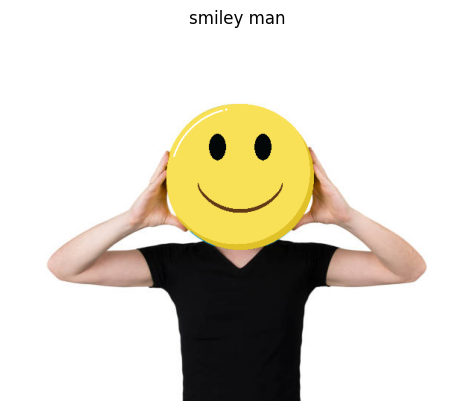

In [6]:
max_area = 0
target_cnt = None
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > max_area:
        max_area = area
        target_cnt = cnt

overlay = cv2.imread("smiley_emoji.png", cv2.IMREAD_UNCHANGED)  # must be RGBA
if overlay is None:
    raise ValueError("Pacman overlay image not found")

if target_cnt is not None:
    x, y, w, h = cv2.boundingRect(target_cnt)

    overlay_resized = cv2.resize(overlay, (w, h))
    b, g, r, a = cv2.split(overlay_resized)
    overlay_rgb = cv2.merge((b, g, r))
    mask = a / 255.0  # normalize alpha to [0, 1]
    mask_3ch = np.stack([mask]*3, axis=-1)
    roi = img[y:y+h, x:x+w].astype(float)
    composite = (roi * (1 - mask_3ch) + overlay_rgb * mask_3ch).astype(np.uint8)

    # Put composite back into image
    img[y:y+h, x:x+w] = composite

    show_img(img, "smiley man")

# Demo2

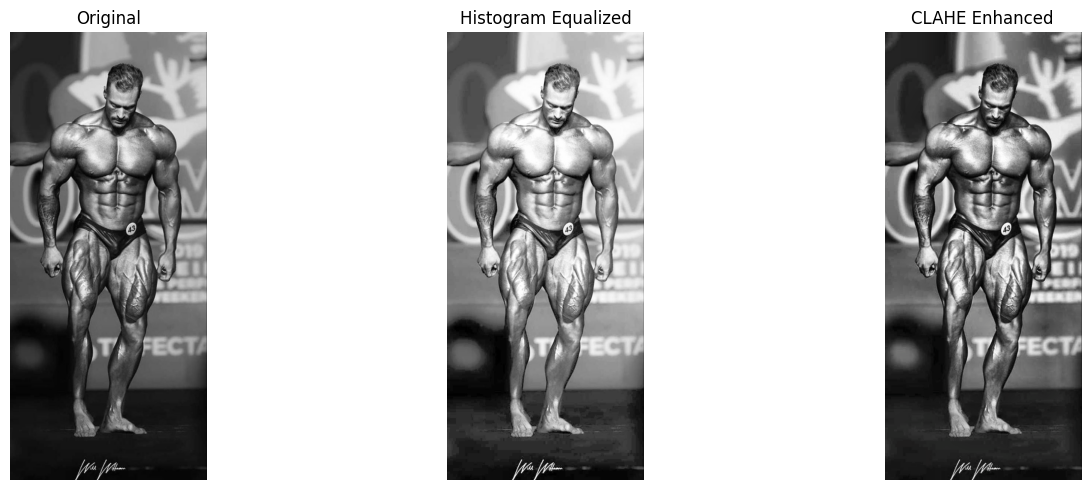

In [7]:
img = cv2.imread("cbum.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equalized = cv2.equalizeHist(gray)

# CLAHE processing
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
cl = clahe.apply(l)
merged = cv2.merge((cl, a, b))
enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

# Plot
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
eq_rgb = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
clahe_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 5))
titles = ["Original", "Histogram Equalized", "CLAHE Enhanced"]
images = [img_rgb, eq_rgb, clahe_rgb]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()